# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [0]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



import re


import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd

filtered_data= pd.read_csv('/content/drive/My Drive/data.csv')

#give reviews with score>1 positive rating(1) and reviews with negative rating(0)
def partition(x):
  if x<3:
    return 0
  return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 11)


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
filtered_data=filtered_data.drop( 'Unnamed: 0',axis=1) 

# **Text Data Cleaning: Deduplication**

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
filtered_data[(filtered_data['Time']== 1199577600) & (filtered_data['ProfileName'] == "Geetha Krishnan")]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
67901,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
72060,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
127440,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
127478,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
142859,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...




As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#sort the data in ascending order with respect to the product id
sorted_data= filtered_data.sort_values('ProductId',axis =0, ascending= True , inplace= False, kind= 'quicksort')

In [0]:
#deleting duplicate data
final = sorted_data.drop_duplicates(subset ={'UserId','Time', 'Text','ProfileName'}, keep= 'first', inplace= False)

In [10]:
final.shape

(364173, 10)

In [11]:
#check percentage of data retained
(final['Id'].size*1.0 / sorted_data['Id'].size*1.0) *100

69.25890143662969

It is also observed that for some entries the helpfulness numerator is greater than helpfulness denominator which is completely absurd.


In [12]:
final[final['HelpfulnessNumerator'] > final['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final =final[ final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]

In [14]:
print(final.shape)

(364171, 10)


# Pre processing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.
Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags. 
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric.
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters).
Convert the word to lowercase.
Remove Stopwords

After which we collect the words used to describe positive and negative reviews

In [15]:
# print some random reviews
rev0 = final['Text'].values[0]
print(rev0)
print("="*50)
rev1 = final['Text'].values[100]
print(rev1)
print("="*50)
rev2 = final['Text'].values[1000]
print(rev2)
print("="*50)



this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
Pros:<br />Dog will do anything for this treat.<br />Doesn't smell as bad as many other treats.<br />Easy to break into smaller pieces.<br />Nothing artificial, easy digestion.<br /><br />Cons:<br />More costly than other dog treats.<br /><br />Overall, this is a great product. While more expensive, my dog will do anything for this treat. He has several phobias, including getting in and out of the car, and walking through doorways, but he ignores all of his fears to get to this treat.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise

In [0]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
print(rev0)
rev0 = decontracted(rev0)
print(rev0)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
this witty little book makes my son laugh at loud. i recite it in the car as we are driving along and he always can sing the refrain. he is learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
   
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:05<00:00, 2902.27it/s]


In [20]:
preprocessed_reviews[100]


'pros dog anything treat not smell bad many treats easy break smaller pieces nothing artificial easy digestion cons costly dog treats overall great product expensive dog anything treat several phobias including getting car walking doorways ignores fears get treat'

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_1, y_train, y_1 = train_test_split(preprocessed_reviews, final['Score'], test_size=0.30, random_state=0)
X_cv, X_test,y_cv,y_test= train_test_split(X_1,y_1 ,test_size=0.50, random_state=0)
print("size of training data", len(X_train))
print("size of cross validation data", len(X_cv))
print("size of test data", len(X_test))
del(preprocessed_reviews)
del(final) 

size of training data 254919
size of cross validation data 54626
size of test data 54626


# Featurization

## Bag of Words

In [22]:
##vectorization of training data
count_vec= CountVectorizer(min_df=10)
count_vec.fit(X_train)
print("Some features" , count_vec.get_feature_names()[56:70])
print('.'*50)
bow_train = count_vec.transform(X_train)
print(type(bow_train))
print("the shape of out text BOW vectorizer of training set",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])
##vectorization of cross validation data and training set

bow_cv= count_vec.transform(X_cv)
print("the shape of out text BOW vectorizer of cross validation ",bow_cv.get_shape())
bow_test=count_vec.transform(X_test)
print("the shape of out text BOW vectorizer of test set ",bow_test.get_shape())

Some features ['accented', 'accents', 'accentuate', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessible', 'accessories', 'accessory', 'accident']
..................................................
<class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer of training set (254919, 19388)
the number of unique words  19388
the shape of out text BOW vectorizer of cross validation  (54626, 19388)
the shape of out text BOW vectorizer of test set  (54626, 19388)


In [0]:
# noramalizing the data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train = preprocessing.normalize(bow_train)
bow_cv = preprocessing.normalize(bow_cv)
bow_test= preprocessing.normalize(bow_test)

## Tf-Idf

In [24]:
tf_idf_vec= TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_vec.fit(X_train)
print("Some unique features", tf_idf_vec.get_feature_names()[:10])

tfidf_train= tf_idf_vec.transform(X_train)
print("the type of count vectorizer ",type(tfidf_train))
print("the shape of out text TFIDF vectorizer train ",tfidf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_train.get_shape()[1])


tfidf_cv= tf_idf_vec.transform(X_cv)
print("the shape of out text TFIDF vectorizer cv",tfidf_cv.get_shape())
tfidf_test= tf_idf_vec.transform(X_test)
print("the shape of out text TFIDF vectorizer test",tfidf_test.get_shape())


Some unique features ['aa', 'aaa', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey', 'abby', 'abc']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer train  (254919, 144520)
the number of unique words including both unigrams and bigrams  144520
the shape of out text TFIDF vectorizer cv (54626, 144520)
the shape of out text TFIDF vectorizer test (54626, 144520)


In [0]:
  # noramalizing the data
from sklearn.preprocessing import Normalizer
tfidf_train = preprocessing.normalize(tfidf_train)
tfidf_cv = preprocessing.normalize(tfidf_cv)
tfidf_test= preprocessing.normalize(tfidf_test)

## Word2Vec

In [0]:
#for training the w2v model with the training document corpus
i=0
list_of_sentance=[]
for sentance in X_train:

    list_of_sentance.append(sentance.split())

In [27]:
# considering the words that oocurs atleast 10 times in the document corpus
w2v_model=Word2Vec(list_of_sentance,min_count=10,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
del(list_of_sentance)

[('good', 0.8730750679969788), ('fantastic', 0.8643936514854431), ('terrific', 0.8456370234489441), ('awesome', 0.8448546528816223), ('excellent', 0.8357987403869629), ('wonderful', 0.7921571135520935), ('perfect', 0.7695950865745544), ('nice', 0.7244323492050171), ('fabulous', 0.720025897026062), ('decent', 0.7093763947486877)]
[('nastiest', 0.8474775552749634), ('greatest', 0.7849010229110718), ('best', 0.7280848026275635), ('disgusting', 0.7267323732376099), ('terrible', 0.7205352783203125), ('awful', 0.6988876461982727), ('vile', 0.6987225413322449), ('horrible', 0.6869615912437439), ('tastiest', 0.6854913234710693), ('horrid', 0.674048662185669)]


In [28]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 10 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 10 times  20364
sample words  ['never', 'much', 'sweet', 'potato', 'fan', 'shopping', 'whole', 'foods', 'trying', 'find', 'snack', 'conducive', 'gluten', 'free', 'diet', 'decided', 'try', 'delicious', 'simple', 'ingredients', 'tastier', 'chip', 'recently', 'tried', 'food', 'taste', 'good', 'brand', 'chips', 'really', 'disappointed', 'better', 'perfect', 'amount', 'crunch', 'salt', 'others', 'either', 'crunchy', 'not', 'salty', 'enough', 'ca', 'recommend', 'yummy', 'healthy', 'mixing', 'stix', 'water', 'bottle']


###Converting the sentences into vectors using average w2v

In [0]:
def avgw2v(X,w2v_model):
  i=0
  list_of_sentance=[]
  w2v_words = list(w2v_model.wv.vocab)
  for sentance in X:
   list_of_sentance.append(sentance.split())
  sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
  return (sent_vectors)

In [30]:
w2v_train= avgw2v(X_train,w2v_model)#for training data
w2v_cv= avgw2v(X_cv,w2v_model)#for cv data
w2v_test= avgw2v(X_test,w2v_model)#for testing data
print("Shape of training data ", len(w2v_train))
print("Shape of cv data ", len(w2v_cv))
print("Shape of testing data ", len(w2v_test))

100%|██████████| 54626/54626 [01:51<00:00, 491.44it/s]

Shape of training data  254919
Shape of cv data  54626
Shape of testing data  54626


In [0]:
  # noramalizing the data
w2v_train = preprocessing.normalize(w2v_train)
w2v_cv = preprocessing.normalize(w2v_cv)
w2v_test= preprocessing.normalize(w2v_test)

#Logistic regression on AFF

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

##Training the model

In [0]:
#trainig with L1 regularization
def Logistic_l1(X_train,X_cv,y_train,y_cv):
 best_C=0
 max_roc_auc= -1
 auc_train=[]
 auc_cv=[]
 Cs=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001] 
 probs=[] # probability values for best alpha
 for i in Cs[-19:]:
    clf= LogisticRegression(penalty='l1',C=i,solver='liblinear')
    clf.fit(X_train,y_train)
    pred_train= clf.predict_proba(X_train)
    pred_cv= clf.predict_proba(X_cv)
    auc_score_train= roc_auc_score(y_train,pred_train[:,1])
    auc_score_cv= roc_auc_score(y_cv,pred_cv[:,1])
    print("C-->", i,"   auc_cv-->",auc_score_cv,"   auc_train-->",auc_score_train)
    auc_train.append( auc_score_train)
    auc_cv.append( auc_score_cv)
    if(auc_score_cv>max_roc_auc):
      max_roc_auc= auc_score_cv
      best_C= i
      probs=pred_cv
      prob=pred_train
 print(best_C, " is the best value of C with an roc_auc score of ", max_roc_auc)
 sns.set_style("darkgrid")
 plt.xscale("log")
 plt.plot(Cs,auc_train,'r-', label="training data")
 plt.plot(Cs,auc_cv,'g-', label="Cv data")
 plt.legend(loc='lower right')
 plt.title(r'Auc Score v/s C')
 plt.xlabel(r"C", fontsize= 12)
 plt.ylabel("auc value", fontsize= 12)
 plt.show()
 #for roc curve
 fpr, tpr, thresholds = metrics.roc_curve(y_cv,probs[:,1])
 plt.plot([0,1],[0,1],linestyle='--')# for a random(dumb) model
 plt.plot(fpr,tpr,marker='.',label='Cross Validation')
 fpr, tpr, thresholds = metrics.roc_curve(y_train,prob[:,1])
 plt.plot(fpr,tpr,marker='.',label='Training',markerfacecolor='blue')
 plt.title(r"ROC curve with best C ")
 plt.xlabel("false positive rate", fontsize=12)
 plt.ylabel("True positive rate", fontsize=12)
 plt.legend(loc="lower right")
 plt.show()
 return(best_C)
 
  


In [0]:
#trainig with L2 regularization
def Logistic_l2(X_train,X_cv,y_train,y_cv):
 best_C=0
 max_roc_auc= -1
 auc_train=[]
 auc_cv=[]
 Cs=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001] 
 probs=[] # probability values for best alpha
 for i in Cs[-19:]:
    clf= LogisticRegression(penalty='l2',C=i)
    clf.fit(X_train,y_train)
    pred_train= clf.predict_proba(X_train)
    pred_cv= clf.predict_proba(X_cv)
    auc_score_train= roc_auc_score(y_train,pred_train[:,1])
    auc_score_cv= roc_auc_score(y_cv,pred_cv[:,1])
    print("C-->" ,i,"   auc_cv-->",auc_score_cv,"   auc_train-->",auc_score_train)
    auc_train.append( auc_score_train)
    auc_cv.append( auc_score_cv)
    if(auc_score_cv>max_roc_auc):
      max_roc_auc= auc_score_cv
      best_C= i
      probs=pred_cv
      prob=pred_train
 print(best_C, " is the best value of C with an roc_auc score of ", max_roc_auc)
 sns.set_style("darkgrid")
 plt.xscale("log")
 plt.plot(Cs,auc_train,'r-', label="training data")
 plt.plot(Cs,auc_cv,'g-', label="Cv data")
 plt.legend(loc='lower right')
 plt.title(r'Auc Score v/s C')
 plt.xlabel(r"C", fontsize= 12)
 plt.ylabel("auc value", fontsize= 12)
 plt.show()
 #for roc curve
 fpr, tpr, thresholds = metrics.roc_curve(y_cv,probs[:,1])
 plt.plot([0,1],[0,1],linestyle='--')# for a random(dumb) model
 plt.plot(fpr,tpr,marker='.',label='Cross Validation')
 fpr, tpr, thresholds = metrics.roc_curve(y_train,prob[:,1])
 plt.plot(fpr,tpr,marker='.',label='Training',markerfacecolor='blue')
 plt.title(r"ROC curve with best C ")
 plt.xlabel("false positive rate", fontsize=12)
 plt.ylabel("True positive rate", fontsize=12)
 plt.legend(loc="lower right")
 plt.show()
 return(best_C)

##Testing the model

In [0]:
import scikitplot.metrics as skplt
def testing(clf, X_test, y_test,optimal_C):
  probs= clf.predict_proba(X_test)
  probs= probs[:,1] #keeping probabilities of positive classes only
  print("AUC score on test data", roc_auc_score(y_test,probs))
  #plotting the roc curve
  fpr, tpr, thresholds= metrics.roc_curve(y_test, probs)
  plt.plot([0,1],[0,1],linestyle='--')# for a random(dumb) model
  plt.plot(fpr,tpr,marker='.')
  plt.title(r"ROC curve on test data with best C")
  plt.xlabel("false positive rate", fontsize=12)
  plt.ylabel("True positive rate", fontsize=12)
  plt.show()
  prediction = clf.predict(X_test)
  skplt.plot_confusion_matrix(y_test,prediction)
  print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
  print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
  print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
  print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

##Important features

In [0]:
def imp_feature(vectorizer,classifier, n =10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    df_imp=pd.DataFrame(columns={'Negative Importance','Negative Word',"Positive Importance",'Positive Word'})
    neg_imp=[]
    neg_word=[]
    pos_imp=[]
    pos_word=[]
    for (coef_1, fn_1), (coef_2, fn_2) in top:
      neg_imp.append(coef_1)
      neg_word.append(fn_1)
      pos_imp.append(coef_2)
      pos_word.append(fn_2)
    df_imp["Negative Importance"]= neg_imp
    df_imp["Negative Word"]=neg_word
    df_imp["Positive Importance"]=pos_imp
    df_imp["Positive Word"]= pos_word
    return df_imp

## Sparsity on L1 regularizer

In [0]:
def sparsity(X_train,X_test,y_train,y_test):
  C_value = [1000,100,10,5,1,0.1,0.01,0.001,0.0001]
  for i in C_value[-9:]:
    clf= LogisticRegression(penalty='l1',C=i,solver='liblinear')
    clf.fit(X_train,y_train)
    pred=clf.predict_proba(X_test)
    print("C = ",i,"auc_score on test data = ",roc_auc_score(y_test,pred[:,1]))
    print("Nmber of non Zero weights  ",np.count_nonzero(clf.coef_))
    print("."*50)


##Pertubation test on L2 regularization



In [0]:
def pertubation_test(clf,X_train,y_train,vectorizer):
  W0 = clf.coef_
  eps= np.random.normal(0,0.1,1)
  X_train.data +=eps
  clf= LogisticRegression(C=5)
  clf.fit(X_train,y_train)
  W1=clf.coef_
  #adding a small value to prevent divisiblity by zero
  W0=W0+0.001
  W1=W1+0.001
  percentage_change_vector = abs((W1-W0)/W0) *100
  x=np.array(range(0,W1.shape[1]))
  plt.plot(x,percentage_change_vector[0])
  print("number of features with more than 1000 percent of change",percentage_change_vector[np.where(percentage_change_vector > 1000)].size)
  #top 10 collinear features
  print("Top 10 collinear features")
  index= np.argsort(abs(W1-W0))[::-1]
  features= vectorizer.get_feature_names()
  features= np.array(features)
  Collinear_features =features[index]
  print(Collinear_features[0:10])
  



#Bag of Words implementation

##L1 regularization

C--> 10000    auc_cv--> 0.923436306838026    auc_train--> 0.9827500341779891
C--> 5000    auc_cv--> 0.9249799020555429    auc_train--> 0.9827410489524737
C--> 1000    auc_cv--> 0.9290961711000193    auc_train--> 0.9826915041855986
C--> 500    auc_cv--> 0.9314072774122183    auc_train--> 0.9826416938294604
C--> 100    auc_cv--> 0.9395292437389022    auc_train--> 0.9822486909760435
C--> 50    auc_cv--> 0.9446871653355676    auc_train--> 0.9816989749373506
C--> 10    auc_cv--> 0.9560536287787218    auc_train--> 0.9773748344578679
C--> 5    auc_cv--> 0.9586393657872747    auc_train--> 0.9734765573184987
C--> 1    auc_cv--> 0.9575767352281196    auc_train--> 0.962901800658214
C--> 0.5    auc_cv--> 0.9541383873057973    auc_train--> 0.957874810925329
C--> 0.1    auc_cv--> 0.9385599380117231    auc_train--> 0.9409049602089115
C--> 0.05    auc_cv--> 0.9261969076458255    auc_train--> 0.9284546341675759
C--> 0.01    auc_cv--> 0.8639574306419515    auc_train--> 0.8663126639706656
C--> 0.005    a

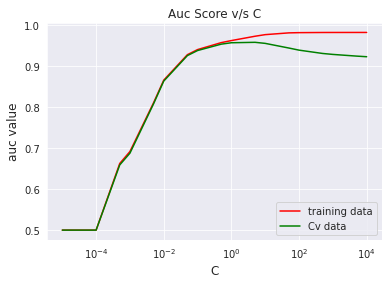

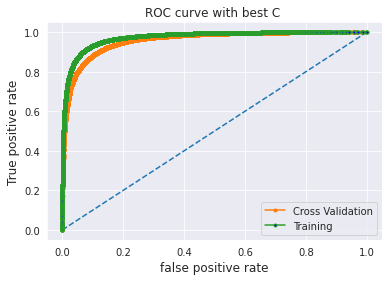

In [39]:
optimal_C=Logistic_l1(bow_train,bow_cv,y_train,y_cv)

AUC score on test data 0.9587429908225292


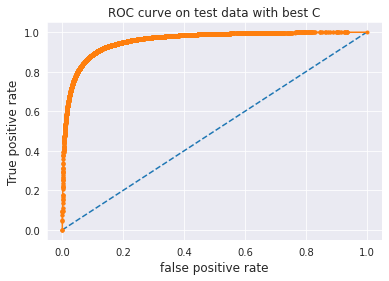

macro f1 score for data : 0.8633955686890744
micro f1 scoore for data: 0.9309486325193131
hamming loss for data: 0.06905136748068685
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77      8646
           1       0.95      0.97      0.96     45980

    accuracy                           0.93     54626
   macro avg       0.89      0.85      0.86     54626
weighted avg       0.93      0.93      0.93     54626



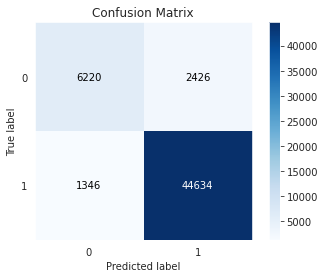

In [40]:
clf_1= LogisticRegression(penalty='l1',C=optimal_C,solver='liblinear')
clf_1.fit(bow_train,y_train)
#testing the model
testing(clf_1, bow_test, y_test,optimal_C)


In [41]:
#imporatant features
imp_feature(count_vec,clf_1, n =10)

,Positive Word,Negative Importance,Negative Word,Positive Importance
0,pleasantly,-22.757028,weakest,20.489349
1,transitioning,-21.211131,unacceptable,19.077751
2,easiest,-20.233168,dissapointing,16.519587
3,deducted,-19.847443,redeeming,16.421303
4,decorator,-19.089698,unimpressive,16.014046
5,addicting,-18.921506,downhill,15.680949
6,downside,-17.979072,implicated,15.244090
7,sc,-17.517282,lawsuit,15.169929
8,delicous,-17.514885,disappointing,15.073843
9,reservation,-17.347615,microscopic,14.780769


##L2 regularization

C--> 10000    auc_cv--> 0.9574760932491562    auc_train--> 0.9692291606420196
C--> 5000    auc_cv--> 0.9578904962057853    auc_train--> 0.9694354540683072
C--> 1000    auc_cv--> 0.9578624935864003    auc_train--> 0.9699572718569588
C--> 500    auc_cv--> 0.9570759463090426    auc_train--> 0.9678036372269903
C--> 100    auc_cv--> 0.9578510670852807    auc_train--> 0.9678351843537752
C--> 50    auc_cv--> 0.9574884377035771    auc_train--> 0.9691330483685787
C--> 10    auc_cv--> 0.9592916132182683    auc_train--> 0.9697106533220137
C--> 5    auc_cv--> 0.9592480961793541    auc_train--> 0.9682316034016024
C--> 1    auc_cv--> 0.9568885224372237    auc_train--> 0.9624715802422187
C--> 0.5    auc_cv--> 0.9544137505994973    auc_train--> 0.9588753652052204
C--> 0.1    auc_cv--> 0.9427493835697704    auc_train--> 0.9453832188355187
C--> 0.05    auc_cv--> 0.9342293747865711    auc_train--> 0.9365486034367254
C--> 0.01    auc_cv--> 0.9000609160367459    auc_train--> 0.9025615036556921
C--> 0.005  

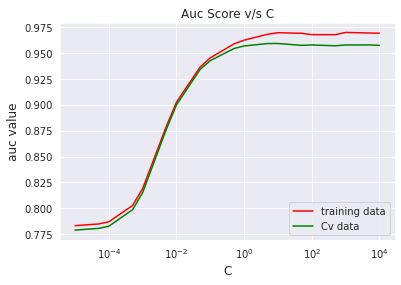

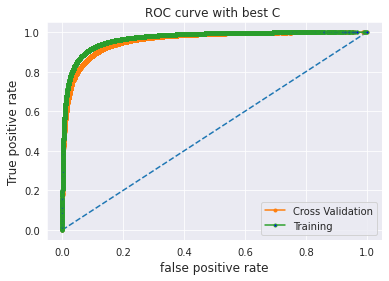

In [42]:
optimal_C=Logistic_l2(bow_train,bow_cv,y_train,y_cv)

AUC score on test data 0.9594284083626862


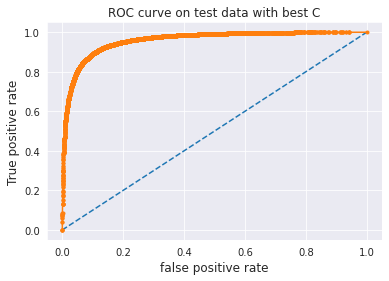

macro f1 score for data : 0.8628256272339242
micro f1 scoore for data: 0.9310035514223995
hamming loss for data: 0.06899644857760041
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77      8646
           1       0.95      0.97      0.96     45980

    accuracy                           0.93     54626
   macro avg       0.89      0.84      0.86     54626
weighted avg       0.93      0.93      0.93     54626



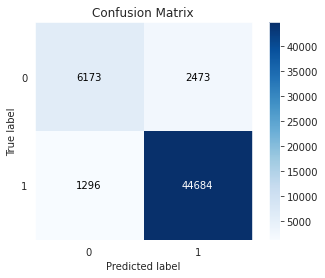

In [43]:
clf_2= LogisticRegression(penalty='l2',C=optimal_C)
clf_2.fit(bow_train,y_train)
#testing the model
testing(clf_2, bow_test, y_test,optimal_C)


In [44]:
#imporatant features
imp_feature(count_vec,clf_2, n =10)

,Positive Word,Negative Importance,Negative Word,Positive Importance
0,pleasantly,-15.069155,disappointing,15.556384
1,hooked,-14.866283,disappointment,13.579880
2,skeptical,-14.154941,worst,11.794551
3,beat,-12.313863,ruined,11.261057
4,perfect,-12.300289,terrible,11.116337
5,worried,-12.272666,sounded,10.903954
6,worry,-11.704287,undrinkable,10.706856
7,downside,-11.676307,hopes,9.993678
8,yum,-11.240639,inedible,9.878848
9,addictive,-11.190482,yuck,9.726823


##Sparsity test on L1 regularizer

In [45]:
sparsity(bow_train,bow_test,y_train,y_test)

C =  1000 auc_score on test data =  0.9313256704153926
Nmber of non Zero weights   19208
..................................................
C =  100 auc_score on test data =  0.941231842093692
Nmber of non Zero weights   18117
..................................................
C =  10 auc_score on test data =  0.956316189681883
Nmber of non Zero weights   11508
..................................................
C =  5 auc_score on test data =  0.9587426336285365
Nmber of non Zero weights   8122
..................................................
C =  1 auc_score on test data =  0.9580136836993867
Nmber of non Zero weights   2700
..................................................
C =  0.1 auc_score on test data =  0.9398570942298883
Nmber of non Zero weights   540
..................................................
C =  0.01 auc_score on test data =  0.8668305356994266
Nmber of non Zero weights   72
..................................................
C =  0.001 auc_score on test data =  0.

##Pertubation test

number of features with more than 1000 percent of change 370
Top 10 collinear features
[['cinch' 'arabic' 'chilling' ... 'disappointing' 'pleasantly' 'worst']]


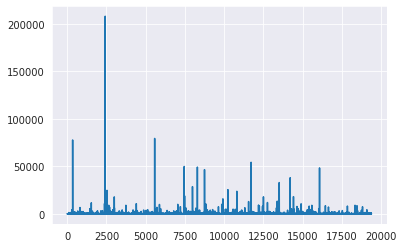

In [48]:
pertubation_test(clf_2,bow_train,y_train,count_vec)

#Tf-idf implementation

##L1 regularization

C--> 10000    auc_cv--> 0.9535953977533642    auc_train--> 0.9999915831775167
C--> 5000    auc_cv--> 0.9539069344595692    auc_train--> 0.9999967584340312
C--> 1000    auc_cv--> 0.9578368526792861    auc_train--> 0.9999967580839575
C--> 500    auc_cv--> 0.9585043787368597    auc_train--> 0.9999967478151284
C--> 100    auc_cv--> 0.960354888110029    auc_train--> 0.9999874364375957
C--> 50    auc_cv--> 0.9615280500818577    auc_train--> 0.9999680845373144
C--> 10    auc_cv--> 0.9664014111988634    auc_train--> 0.9997651915521193
C--> 5    auc_cv--> 0.969586681413536    auc_train--> 0.9970312265864497
C--> 1    auc_cv--> 0.9688687889731858    auc_train--> 0.9749579393716962
C--> 0.5    auc_cv--> 0.9641243082474779    auc_train--> 0.9675612731963269
C--> 0.1    auc_cv--> 0.9416421150094966    auc_train--> 0.9440683529653255
C--> 0.05    auc_cv--> 0.9250899467512185    auc_train--> 0.9272868184560727
C--> 0.01    auc_cv--> 0.819382712820481    auc_train--> 0.8214548441779682
C--> 0.005    a

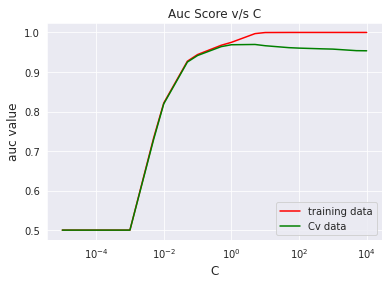

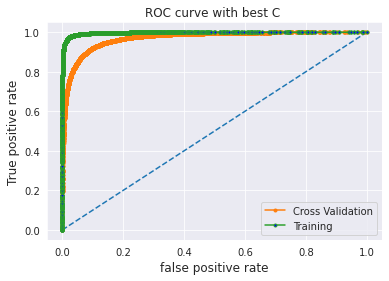

In [49]:
optimal_C=Logistic_l1(tfidf_train,tfidf_cv,y_train,y_cv)

AUC score on test data 0.969138905650175


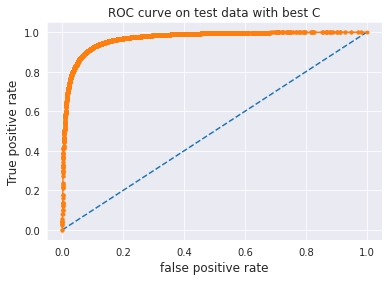

macro f1 score for data : 0.8875839803789096
micro f1 scoore for data: 0.9421154761468897
hamming loss for data: 0.05788452385311024
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      8646
           1       0.96      0.97      0.97     45980

    accuracy                           0.94     54626
   macro avg       0.90      0.87      0.89     54626
weighted avg       0.94      0.94      0.94     54626



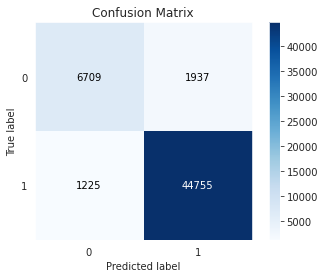

In [50]:
clf_1= LogisticRegression(penalty='l1',C=optimal_C,solver='liblinear')
clf_1.fit(tfidf_train,y_train)
#testing the model
testing(clf_1, tfidf_test, y_test,optimal_C)


In [52]:
#imporatant features
df=imp_feature(tf_idf_vec,clf_1, n =10)
df[{'Negative Importance','Negative Word',"Positive Importance",'Positive Word'}]

,Positive Word,Negative Importance,Negative Word,Positive Importance
0,not disappointed,-49.683985,two stars,31.962013
1,great,-25.436057,not worth,26.998414
2,delicious,-23.846759,wanted like,24.288529
3,not overpowering,-23.450554,disappointed,23.754546
4,four stars,-23.449317,no thanks,23.089724
5,perfect,-23.033325,not recommend,23.001959
6,not regret,-22.913150,disappointing,22.723352
7,good,-22.073782,mediocre best,21.270256
8,best,-21.821035,worst,21.258858
9,food beverages,-19.996763,disappointment,21.106831


##L2 regularization

C--> 10000    auc_cv--> 0.966056156100864    auc_train--> 0.9989959036741957
C--> 5000    auc_cv--> 0.9665299246610254    auc_train--> 0.9992624137480635
C--> 1000    auc_cv--> 0.9663765886319859    auc_train--> 0.9993209066909852
C--> 500    auc_cv--> 0.9684921860221369    auc_train--> 0.9985939943618504
C--> 100    auc_cv--> 0.9684526156780477    auc_train--> 0.9989673476356319
C--> 50    auc_cv--> 0.9708128703196048    auc_train--> 0.998621021453436
C--> 10    auc_cv--> 0.9730184599173157    auc_train--> 0.997585124605818
C--> 5    auc_cv--> 0.9733180632306057    auc_train--> 0.9935631486252701
C--> 1    auc_cv--> 0.9708071507644207    auc_train--> 0.9837579932755809
C--> 0.5    auc_cv--> 0.9677626754200879    auc_train--> 0.9777872029811325
C--> 0.1    auc_cv--> 0.9553849275391748    auc_train--> 0.9612659604196172
C--> 0.05    auc_cv--> 0.947154691899024    auc_train--> 0.9522012472816294
C--> 0.01    auc_cv--> 0.9240709605843891    auc_train--> 0.9283108751686319
C--> 0.005    au

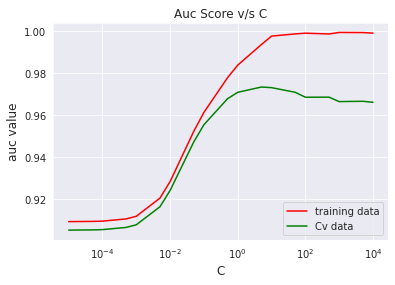

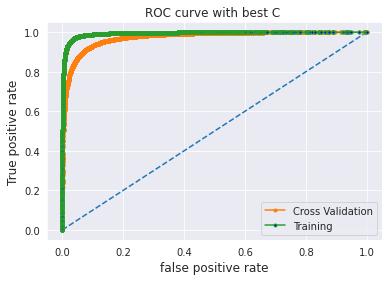

In [55]:
optimal_C=Logistic_l2(tfidf_train,tfidf_cv,y_train,y_cv)

AUC score on test data 0.9726669610247022


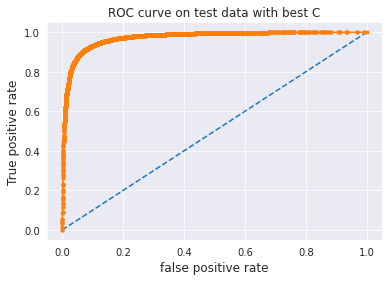

macro f1 score for data : 0.8903783596011265
micro f1 scoore for data: 0.9446783582909237
hamming loss for data: 0.05532164170907626
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      8646
           1       0.96      0.98      0.97     45980

    accuracy                           0.94     54626
   macro avg       0.91      0.87      0.89     54626
weighted avg       0.94      0.94      0.94     54626



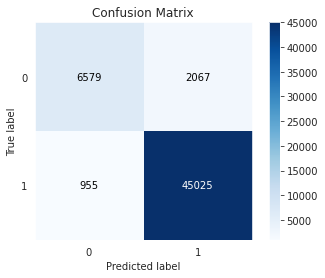

In [56]:
clf_2= LogisticRegression(penalty='l2',C=optimal_C)
clf_2.fit(tfidf_train,y_train)
#testing the model
testing(clf_2, tfidf_test, y_test,optimal_C)


In [57]:
#imporatant features
imp_feature(tf_idf_vec,clf_2, n =10)

,Positive Word,Negative Importance,Negative Word,Positive Importance
0,great,-16.647356,disappointed,19.016283
1,not disappointed,-15.848845,not worth,18.385744
2,delicious,-14.938526,two stars,15.977457
3,best,-14.182724,disappointing,15.591205
4,good,-13.825984,worst,14.673425
5,perfect,-13.740934,not recommend,14.193664
6,loves,-13.014977,not good,11.814024
7,happy,-12.702053,terrible,11.787364
8,excellent,-12.474912,disappointment,11.584358
9,pleased,-11.145155,awful,11.334986


#Word2Vec implementation

##L1 regularization

C--> 10000    auc_cv--> 0.9210357769953808    auc_train--> 0.9212269090191877
C--> 5000    auc_cv--> 0.9210355323759569    auc_train--> 0.9212268954830038
C--> 1000    auc_cv--> 0.9210360619644    auc_train--> 0.9212264891641044
C--> 500    auc_cv--> 0.9210356660339926    auc_train--> 0.9212267263973963
C--> 100    auc_cv--> 0.9210363015401242    auc_train--> 0.921226700491941
C--> 50    auc_cv--> 0.9210358627382713    auc_train--> 0.9212270791550163
C--> 10    auc_cv--> 0.9210359560467114    auc_train--> 0.9212277945890115
C--> 5    auc_cv--> 0.9210360594425503    auc_train--> 0.9212288877525523
C--> 1    auc_cv--> 0.9210388158243034    auc_train--> 0.9212365200598257
C--> 0.5    auc_cv--> 0.921038319019907    auc_train--> 0.9212455313074879
C--> 0.1    auc_cv--> 0.9210053584439559    auc_train--> 0.9212733181757402
C--> 0.05    auc_cv--> 0.9208440558916242    auc_train--> 0.921184145180296
C--> 0.01    auc_cv--> 0.9170294757301634    auc_train--> 0.9179872853761173
C--> 0.005    auc_

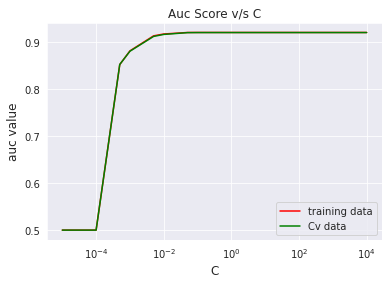

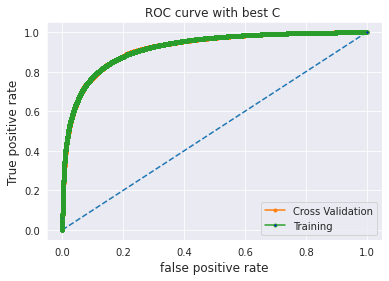

In [58]:
optimal_C=Logistic_l1(w2v_train,w2v_cv,y_train,y_cv)

AUC score on test data 0.9203449233728331


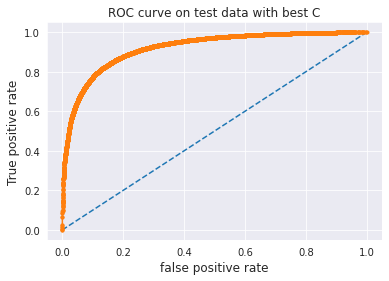

macro f1 score for data : 0.7872060246102485
micro f1 scoore for data: 0.8993336506425512
hamming loss for data: 0.10066634935744884
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.75      0.55      0.63      8646
           1       0.92      0.97      0.94     45980

    accuracy                           0.90     54626
   macro avg       0.83      0.76      0.79     54626
weighted avg       0.89      0.90      0.89     54626



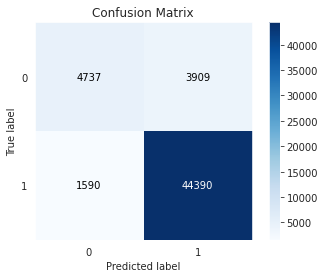

In [60]:
clf_1= LogisticRegression(penalty='l1',C=optimal_C,solver='liblinear')
clf_1.fit(w2v_train,y_train)
#testing the model
testing(clf_1, w2v_test, y_test,optimal_C)


##L2 regularization

C--> 10000    auc_cv--> 0.9210313208869104    auc_train--> 0.9212258814361242
C--> 5000    auc_cv--> 0.9210318227350065    auc_train--> 0.9212259135262153
C--> 1000    auc_cv--> 0.9210310207867928    auc_train--> 0.9212255314790939
C--> 500    auc_cv--> 0.9210313107995114    auc_train--> 0.9212259129427591
C--> 100    auc_cv--> 0.921031288102864    auc_train--> 0.9212257675454736
C--> 50    auc_cv--> 0.9210312376658696    auc_train--> 0.9212257969516662
C--> 10    auc_cv--> 0.9210313511491072    auc_train--> 0.9212278148932874
C--> 5    auc_cv--> 0.9210321959687662    auc_train--> 0.9212298141643102
C--> 1    auc_cv--> 0.9210263452773962    auc_train--> 0.921242883699933
C--> 0.5    auc_cv--> 0.9210146060669102    auc_train--> 0.9212514254987347
C--> 0.1    auc_cv--> 0.920762128559496    auc_train--> 0.9211092557761403
C--> 0.05    auc_cv--> 0.920316764853751    auc_train--> 0.92077719031375
C--> 0.01    auc_cv--> 0.9173901632875759    auc_train--> 0.9182933905382421
C--> 0.005    auc_

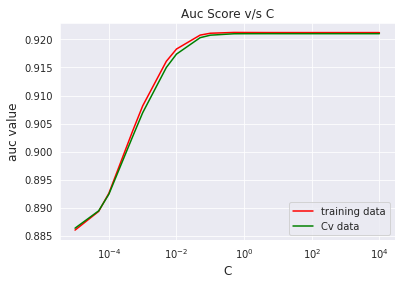

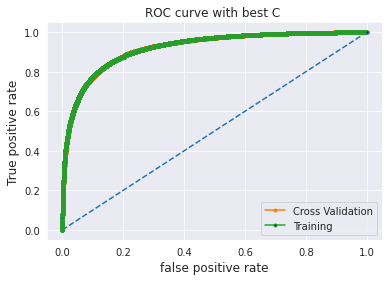

In [62]:
optimal_C=Logistic_l2(w2v_train,w2v_cv,y_train,y_cv)

AUC score on test data 0.9203355457728003


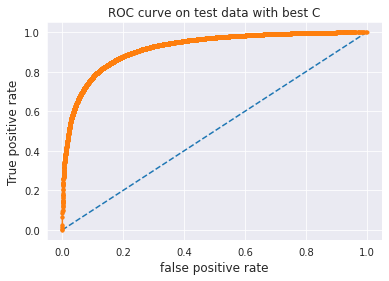

macro f1 score for data : 0.7872805718787861
micro f1 scoore for data: 0.8993519569435799
hamming loss for data: 0.10064804305642001
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.75      0.55      0.63      8646
           1       0.92      0.97      0.94     45980

    accuracy                           0.90     54626
   macro avg       0.83      0.76      0.79     54626
weighted avg       0.89      0.90      0.89     54626



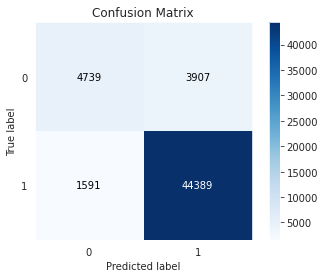

In [63]:
clf_2= LogisticRegression(penalty='l2',C=optimal_C)
clf_2.fit(w2v_train,y_train)
#testing the model
testing(clf_2, w2v_test, y_test,optimal_C)


#Conclusion

In [68]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names= ["Vectorizer","regularization","Best hyper parameter","Test Auc Score"]
x.add_row(["BOW","L1",5,0.9587])
x.add_row(["BOW","L2",5, 0.9594])
x.add_row(["Tf-idf","L1",5,0.9691])
x.add_row(["tf-idf","L2",5,0.9726])
x.add_row(["Word2Vec","L1",5,0.9203])
x.add_row(["Word2Vec","L2",5,0.9203])
print(x)

+------------+----------------+----------------------+----------------+
| Vectorizer | regularization | Best hyper parameter | Test Auc Score |
+------------+----------------+----------------------+----------------+
|    BOW     |       L1       |          5           |     0.9587     |
|    BOW     |       L2       |          5           |     0.9594     |
|   Tf-idf   |       L1       |          5           |     0.9691     |
|   tf-idf   |       L2       |          5           |     0.9726     |
|  Word2Vec  |       L1       |          5           |     0.9203     |
|  Word2Vec  |       L2       |          5           |     0.9203     |
+------------+----------------+----------------------+----------------+
